In [2]:
elastic_rods_dir = '../../../../../elastic_rods/python/'
weaving_dir = '../../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, Visualization_Setting, set_figure_label_and_limit, contact_optimization, get_fixed_boundary_joint, show_selected_joints)

import vis.fields
import matplotlib.cm as cm
import time

In [3]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [4]:
# rod_length = curved_linkage.totalRestLength() / curved_linkage.numSegments()
rod_length = 0.079785061039255
width = rod_length / 25 * 5
thickness = width / 5 * 0.5
print(width, thickness)
scale = 1
io = InputOrganizer('lilium_{}'.format(scale), thickness, width, weaving_dir)

0.015957012207851003 0.0015957012207851004


In [5]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False

In [6]:
rw = 0.01
sw = 0.01

In [7]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [8]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/lilium_1/lilium_1_dof.npy'))

In [9]:
set_surface_view_options(curved_linkage_view, surface_transparent=False)


In [10]:
rw = -0.001

In [11]:
iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

0	0.999002	6.69546	6.69546	1	1
1	0.93984	5.92385	5.92385	1	1
2	0.919576	11.7303	11.7303	1	1
3	0.916042	3.76015	3.76015	1	1
4	0.910662	1.91191	1.91191	1	1
5	0.901108	1.40983	1.40983	1	1
6	0.883406	1.31841	1.31841	1	1
7	0.850899	1.34909	1.34909	1	1
8	0.791829	2.55019	2.55019	0.5	1
9	0.760807	18.2993	18.2993	1	1
10	0.745479	8.51385	8.51385	1	1
11	0.737545	4.14113	4.14113	1	1
12	0.73177	2.20492	2.20492	1	1
13	0.724414	1.32471	1.32471	1	1
14	0.711184	1.01067	1.01067	1	1
15	0.685868	1.00255	1.00255	1	1
16	0.638718	1.3092	1.3092	1	1
17	0.563016	2.48393	2.48393	1	1
18	0.533727	1.52889	1.52889	1	1
19	0.51999	1.01344	1.01344	1	1
20	0.496878	0.939198	0.939198	1	1
21	0.460906	1.12452	1.12452	1	1
22	0.417832	4.78877	4.78877	1	1
23	0.412321	1.79684	1.79684	1	1
24	0.408317	0.961977	0.961977	1	1
25	0.402903	0.807564	0.807564	1	1
26	0.393315	0.782233	0.782233	1	1
27	0.375485	0.823399	0.823399	1	1
28	0.343986	1.54518	1.54518	1	1
29	0.330117	0.758627	0.758627	1	1
30	0.307225	1.11514	1.11514	1	1
31	0.2721

In [12]:
curved_linkage.attraction_weight = 1e-5

In [13]:
fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [14]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [15]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

0	0.00192312	0.0129882	0.0129882	1	1
1	0.00180024	0.00950732	0.00950732	0.03125	1
2	0.00179838	0.044368	0.044368	0.5	1
3	0.00179459	0.0268068	0.0268068	1	1
4	0.00178834	0.00312244	0.00312244	1	1
5	0.00178109	0.00259184	0.00259184	1	1
6	0.00176761	0.00237624	0.00237624	1	1
7	0.00174257	0.00213076	0.00213076	1	1
8	0.00169649	0.00225173	0.00225173	1	1
9	0.00161482	0.00363298	0.00363298	1	1
10	0.00148003	0.00733357	0.00733357	1	1
11	0.00128072	0.00886876	0.00886876	0.5	1
12	0.00118381	0.0973108	0.0973108	1	1
13	0.00114583	0.00826167	0.00826167	1	1
14	0.00114291	0.00246665	0.00246665	1	1
15	0.00114003	0.0013781	0.0013781	1	1
16	0.00113514	0.00101818	0.00101818	1	1
17	0.00112595	0.000892279	0.000892279	1	1
18	0.00110842	0.000842815	0.000842815	1	1
19	0.00107558	0.000895689	0.000895689	1	1
20	0.00101691	0.00143639	0.00143639	1	1
21	0.000920687	0.0028819	0.0028819	1	1
22	0.000782793	0.00646713	0.00646713	0.03125	1
23	0.000777662	0.0191237	0.0191237	1	1
24	0.000775546	0.025603	0.025603	1	1
25	0

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = fixed_boundary_joints)
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

stage 2 optimization with attraction weight 100.0


In [ ]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = fixed_boundary_joints)
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [ ]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [ ]:
validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(validation_curved_view)
validation_curved_view.show()

In [ ]:
set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

In [ ]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

## Extra Utility Functions for Fabrication

In [ ]:
mesh_scale = 313.3418671911495

In [ ]:
ribbons = order_segments_by_ribbons(curved_linkage)
new_rod, fixedVars = construct_elastic_rod_loop_from_rod_segments(curved_linkage, ribbons[0])

In [ ]:
new_rod.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, io.RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
single_rod_view = linkage_vis.LinkageViewer(new_rod, width=1024, height=640)

In [ ]:
single_rod_view.show()

In [ ]:
export_linkage_geometry_to_obj(new_rod, 'results/lilium_1/boundary_rod.obj', scale = mesh_scale)

In [ ]:
all_centerline_pos, all_rest_kappas, all_material_frame = concatenate_rod_properties_from_rod_segments(curved_linkage, ribbons[0])

In [ ]:
len(all_material_frame)

In [ ]:
with open('results/lilium_1/boundary_rod_curve.obj', 'w') as f:
    for point in all_centerline_pos:
        point *= mesh_scale
        f.write('v {} {} {}\n'.format(point[0], point[1],point[2]))
    for i in range(len(all_centerline_pos)-1):
        f.write('l {} {}\n'.format(i+1, i+2))
    f.write('l {} {}\n'.format(len(all_centerline_pos), 1))

In [ ]:
point_list = []
edge_list = []
face_list = []
with open('../../../../normalized_objs/surface_models/lilium_1.obj', 'r') as surface, open('results/lilium_1/lilium_surface_scale_{}.obj'.format(str(int(mesh_scale))), 'w') as output_surface:
    surface_content = surface.readlines()
    for line in surface_content:
        if 'v ' in line:
            point = np.array([float(x) for x in line.split(' ')[1:]])
            point *= mesh_scale
            output_surface.write('v {} {} {}\n'.format(point[0], point[1], point[2]))
        else:
            output_surface.write(line)

In [ ]:
curved_linkage.jointPositions()[49 * 3:50 * 3] * mesh_scale

## Contact Optimization

In [7]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [8]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/lilium_1/lilium_1_dof.npy'))

In [9]:
fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [10]:
curved_linkage.attraction_weight = 1e-5

In [11]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [12]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

0	0.000525704	0.504283	0.504283	1	1
1	4.57052e-05	0.176066	0.176066	1	1
2	1.56127e-05	0.0311308	0.0311308	1	1
3	9.47111e-06	0.00888602	0.00888602	1	1
4	7.6571e-06	0.00387817	0.00387817	1	1
5	6.39163e-06	0.00215248	0.00215248	1	1
6	5.30507e-06	0.00116189	0.00116189	1	1
7	4.42351e-06	0.000606137	0.000606137	1	0
8	3.26405e-06	0.00107631	0.00107631	1	0
9	3.25799e-06	1.08932e-05	1.08932e-05	1	0
10	3.2575e-06	1.97367e-05	1.97367e-05	1	0
11	3.2574e-06	5.99084e-07	5.99084e-07	1	0


In [13]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = fixed_boundary_joints)

In [14]:
optimizer.setLinkageAttractionWeight(1e-5)

../../../../../elastic_rods/python/structural_analysis.py:209: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


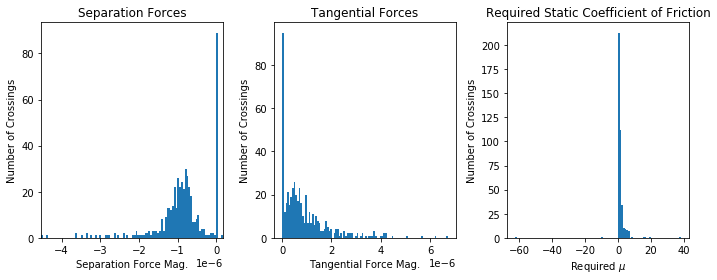

In [15]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [16]:
contact_optimization(optimizer, curved_linkage_view, -1, 1e4)

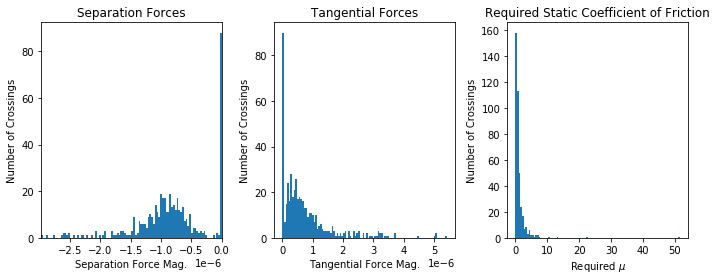

In [ ]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()